# Twitter Analysis

<font size = '3'>Table of Contents
    1. Exploratory Data Analysis
    2. Data Cleansing 
    3. Term Frequency Analysis
    4. Topic Modelling 
    5. Sentiment Analysis 
    6. Word Cloud
    7. Word Cloud - Positive, Negative and Neutral

<font size = "3">Importing the libraries needed for the course of this notebook

In [1]:
import os
import re
import pandas as pd
import numpy as np
import collections
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import gensim
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

<font size = '3'>Importing the Dataset

In [2]:
import pandas as pd
tweets = pd.read_csv('data_elonmusk.csv', encoding='latin1')
tweets = tweets.assign(Time=pd.to_datetime(tweets.Time)).drop('row ID', axis='columns')

print("Number of tweets: ",len(tweets['Tweet']))
tweets.head(5)

Number of tweets:  3218


,Tweet,Time,Retweet from,User
0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


<font size = '4'><b>1. Exploratory Data Analysis

In [3]:
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='lightcoral'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Text(0.5, 1.0, '@elonmusk number of tweets per day')

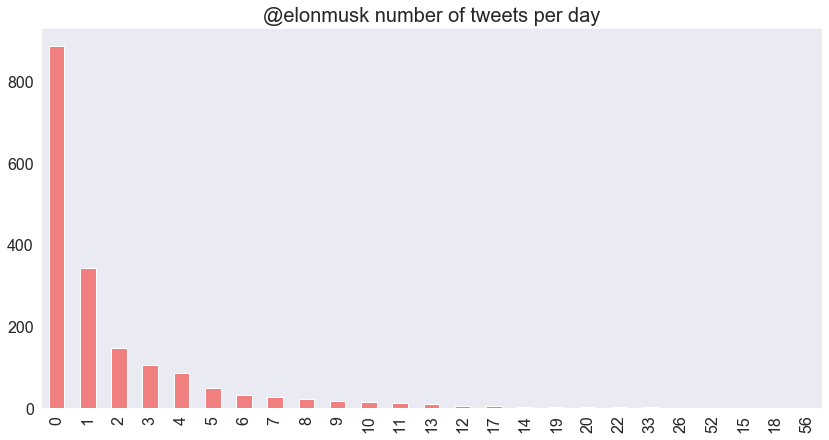

In [4]:
sns.set_style("dark")

(tweets
     .set_index('Time')
     .groupby(pd.TimeGrouper('1D'))
     .Tweet
     .count()
     .value_counts()
     .sort_values(ascending=False)
).plot.bar(figsize=(14, 7), fontsize=16, color='lightcoral')
plt.gca().set_title('@elonmusk number of tweets per day', fontsize=20)

Text(0.5, 1.0, '@elonmusk tweets per hour of day')

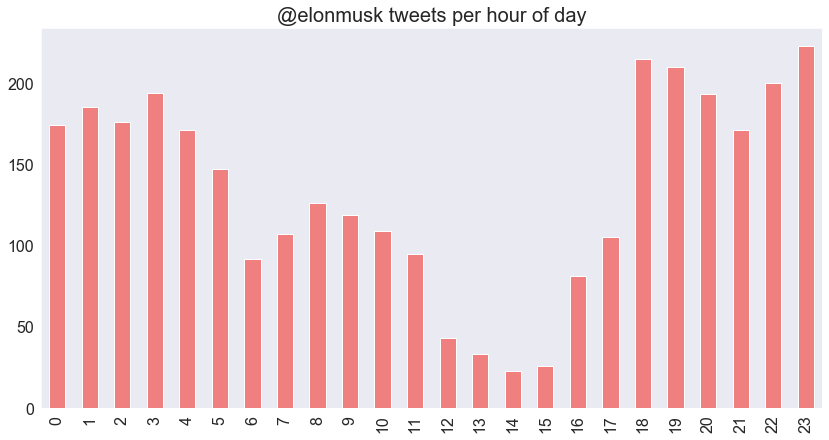

In [5]:
(tweets.Time
     .dt
     .hour
     .value_counts()
     .sort_index()
).plot.bar(figsize=(14, 7), fontsize=16, color='lightcoral')
plt.gca().set_title('@elonmusk tweets per hour of day', fontsize=20)

Text(0.5, 1.0, '@elonmusk tweets per day of year')

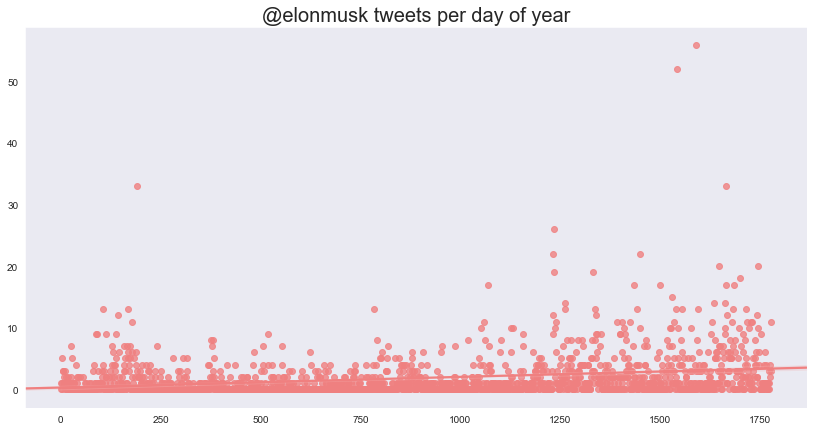

In [6]:
d = (tweets
     .set_index('Time')
     .groupby(pd.TimeGrouper('1D'))
     .Tweet
     .count()
     .sort_index()
     .reset_index()
    )
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()
sns.regplot(d.index.values, d.Tweet.values, ax=ax, color='lightcoral')
ax.set_title('@elonmusk tweets per day of year', fontsize=20)

In [7]:
tweets['Retweet from'].notnull().value_counts() / len(tweets)

False    0.836855
True     0.163145
Name: Retweet from, dtype: float64

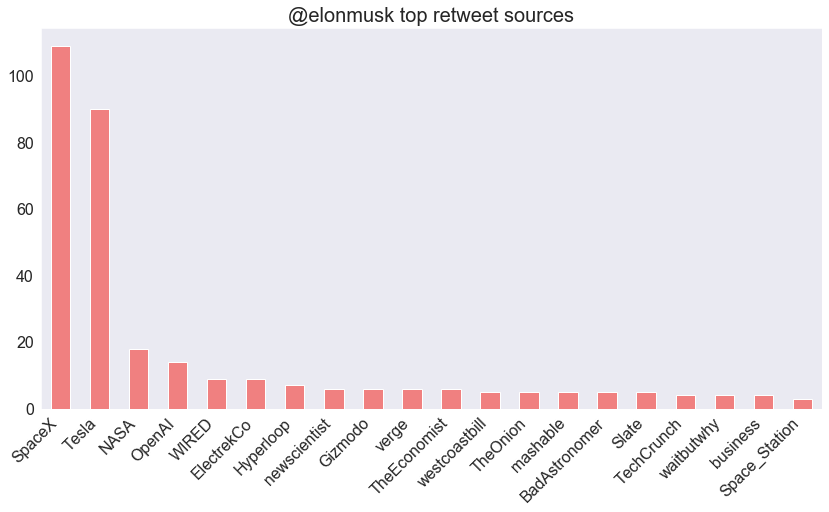

In [8]:
tweets['Retweet from'].value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top retweet sources', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

In [9]:
tweets.Tweet.str.contains('https://').value_counts() / len(tweets)

False    0.748602
True     0.251398
Name: Tweet, dtype: float64

In [10]:
tweets.Tweet.str.contains('@').value_counts() / len(tweets)

True     0.643567
False    0.356433
Name: Tweet, dtype: float64

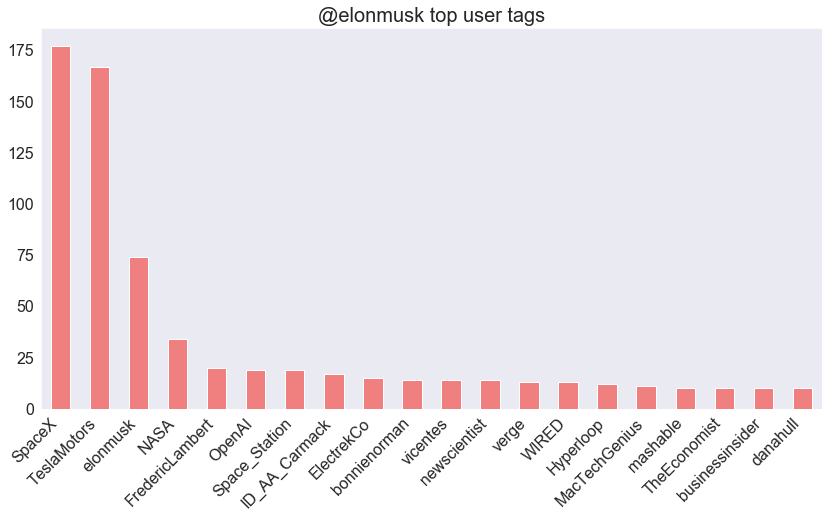

In [11]:
c = list(
itertools.chain(
    *tweets.Tweet.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ")
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

<font size = '4'><b>2. Data Cleansing

In [12]:
# Preparing a corpus for analysis and checking first 10 entries
corpus=[]
a=[]
for i in range(len(tweets['Tweet'])):
        a=tweets['Tweet'][i]
        corpus.append(a)
        
corpus[0:10]

["@MeltingIce Assuming max acceleration of 2 to 3 g's, but in a comfortable direction. Will feel like a mild to moder? https://t.co/fpjmEgrHfC",
 'RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?',
 '@bigajm Yup :)',
 'Part 2 https://t.co/8Fvu57muhM',
 'Fly to most places on Earth in under 30 mins and anywhere in under 60. Cost per seat should be? https://t.co/dGYDdGttYd',
 'RT @SpaceX: Supporting the creation of a permanent, self-sustaining human presence on Mars. https://t.co/kCtBLPbSg8 https://t.co/ra6hKsrOcG',
 'BFR will take you anywhere on Earth in less than 60 mins https://t.co/HWt9BZ1FI9',
 'Mars City\nOpposite of Earth. Dawn and dusk sky are blue on Mars and day sky is red. https://t.co/XHcZIdgqnb',
 'Moon Base Alpha https://t.co/voY8qEW9kl',
 "Will be announcing something really special at today's talk https://t.co/plXTBJY6ia"]

In [13]:
#removing the links from our corpus
no_link_corpus = []
for i in range(len(corpus)):
    no_link_corpus.append(re.sub(r"https\S+", "", corpus[i]))

In [14]:
#removing the mentions in the corpus
no_mention_corpus = []
for i in range(len(no_link_corpus)):
    no_mention_corpus.append(re.sub(r"@\S+","", no_link_corpus[i]))

In [15]:
#removing the hashags in the corpus
no_hashtag_corpus = []
for i in range(len(no_mention_corpus)):
    no_hashtag_corpus.append(re.sub(r"@\S+","", no_mention_corpus[i]))

In [16]:
cleaned_corpus = no_hashtag_corpus

In [17]:
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in cleaned_corpus]

dictionary = corpora.Dictionary(texts)

#print(dictionary)
#print(dictionary.token2id)

In [18]:
corpus_ids = [dictionary.doc2bow(text) for text in texts]

<font size = '4'><b>3. Term Frequency Analysis

In [19]:
clean_tweets = list(itertools.chain(*texts))

In [20]:
counts_tweets = collections.Counter(clean_tweets)

In [21]:
counts_tweets = pd.DataFrame(counts_tweets.most_common(15),
                             columns=['words', 'count'])

In [22]:
counts_tweets.head()

,words,count
0,tesla,313
1,model,240
2,launch,139
3,like,127
4,falcon,121


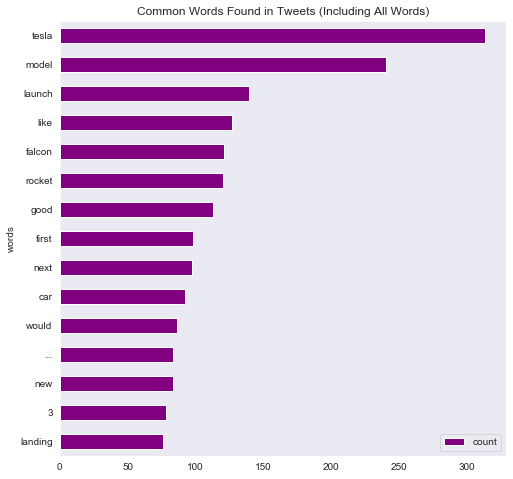

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
counts_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

<font size = '4'><b>4. Topic Modelling

In the previous cells, I created a corpus of documents represented as a stream of vectors. To continue, lets use that corpus, with the help of Gensim.

### Creating a transformation


The transformations are standard Python objects, typically initialized by means of a training corpus:

Different transformations may require different initialization parameters; in case of TfIdf, the “training” consists simply of
going through the supplied corpus once and computing document frequencies of all its features.
Training other models, such as Latent Semantic Analysis or Latent Dirichlet Allocation, is much more involved and,
consequently, takes much more time.

In [24]:
tfidf = models.TfidfModel(corpus_ids) # step 1 -- initialize a model

### Note
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where TfIdf vectors are expected, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

From now on, tfidf is treated as a read-only object that can be used to apply a transformation to a whole corpus:

In [25]:
corpus_tfidf = tfidf[corpus_ids]  # step 2 -- use the model to transform vectors

### LDA:


Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA).

In [26]:
total_topics = 5

In [27]:
lda = models.LdaModel(corpus_ids, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [28]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.010*"falcon" + 0.009*"tesla" + 0.008*"9" + 0.008*"launch" + 0.007*"dragon"'),
 (1,
  '0.009*"tesla" + 0.007*"launch" + 0.007*"rocket" + 0.005*":)" + 0.005*"next"'),
 (2,
  '0.014*"model" + 0.009*"tesla" + 0.009*"like" + 0.007*"..." + 0.004*"car"'),
 (3,
  '0.015*"tesla" + 0.007*"good" + 0.005*"model" + 0.004*"launch" + 0.004*"thanks"'),
 (4,
  '0.006*"model" + 0.005*"i\'m" + 0.004*"tesla" + 0.004*"rocket" + 0.004*"first"')]

In [29]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [30]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 81)


In [31]:
df_lda

,#dragon,...,3,9,:),actually,article,autopilot,back,best,...,us,v,video,vs,w,work,would,x,yes,"yes,"
0,0.002596,0.000000,0.000000,0.008471,0.000000,0.000000,0.000000,0.000000,0.003161,0.000000,...,0.000000,0.000000,0.00495,0.000000,0.000000,0.000000,0.000000,0.000000,0.003589,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.005226,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.002043,0.002510,0.000000,0.000000,0.000000
2,0.000000,0.007421,0.002359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002991,...,0.002901,0.002257,0.00000,0.002261,0.000000,0.000000,0.004018,0.002592,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.002533,0.002529,0.003047,0.000000,0.003534,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.002138,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.002257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.003372,0.002319,0.002280,0.000000,0.000000,0.002488


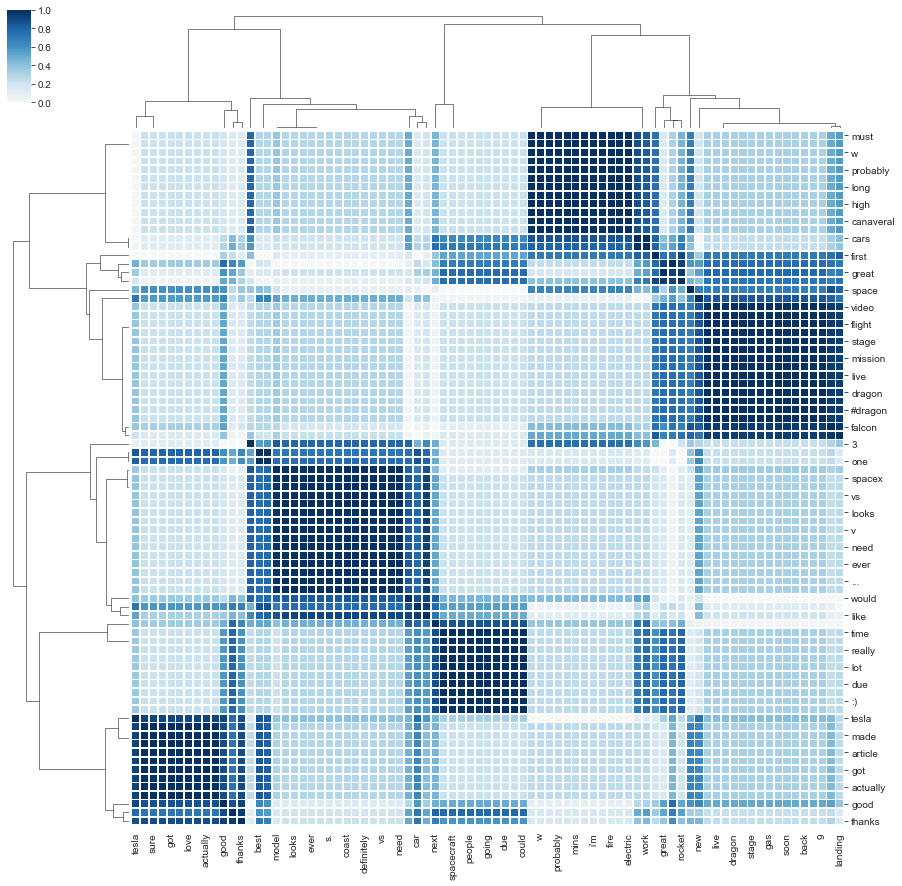

In [32]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

<font size = '4'><b>5. Sentiment Analysis

In [33]:
tweets['Cleaned_Tweet'] = cleaned_corpus

In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


tweets['Vader_Score'] = pd.Series('NaN')
for i in range(len(tweets)):
    tweets['Vader_Score'][i] = analyser.polarity_scores(tweets['Cleaned_Tweet'][i])

In [35]:
positives = 0
for i in range(len(tweets)):
    positives += tweets['Vader_Score'][i]['pos']
    
negatives = 0
for i in range(len(tweets)):
    negatives += tweets['Vader_Score'][i]['neg']
    
neutrals = 0
for i in range(len(tweets)):
    neutrals += tweets['Vader_Score'][i]['neu']

compounds = 0
for i in range(len(tweets)):
    compounds+=tweets['Vader_Score'][i]['compound']

In [36]:
positives, negatives, neutrals, compounds

(553.5950000000012, 144.504, 2506.894000000001, 575.5328000000013)

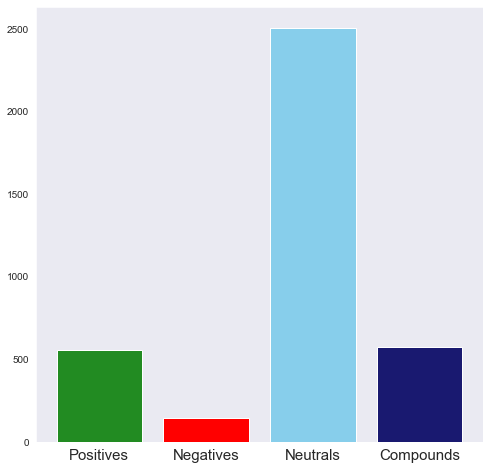

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
height = [553.5950000000012, 144.504, 2506.894000000001, 575.5328000000013]
bars = ('Positives', 'Negatives', 'Neutrals', 'Compounds')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color=['forestgreen', 'red', 'skyblue', 'midnightblue'])
 
# Create names on the x-axis
plt.xticks(y_pos, bars, fontsize=15)
 
# Show graphic
plt.show()

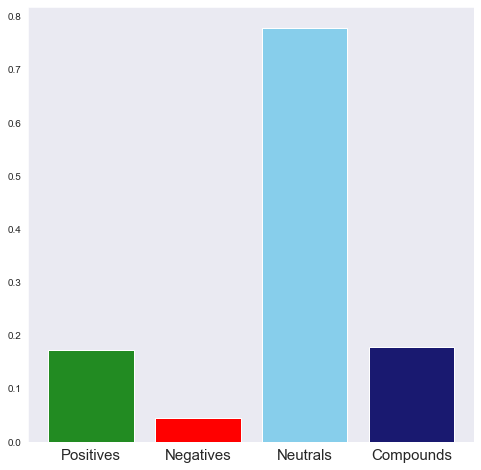

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
avg_height = [ x/len(tweets) for x in height]
bars = ('Positives', 'Negatives', 'Neutrals', 'Compounds')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, avg_height, color=['forestgreen', 'red', 'skyblue', 'midnightblue'] )
 
# Create names on the x-axis
plt.xticks(y_pos, bars, fontsize=15)
 
# Show graphic
plt.show()

<font size = '3'>It is clear that an average tweet by Elon Musk mostly contains of a neutral talk followed by a positives, compounds and Negatives

<font size = '4'><b>6. Word Cloud

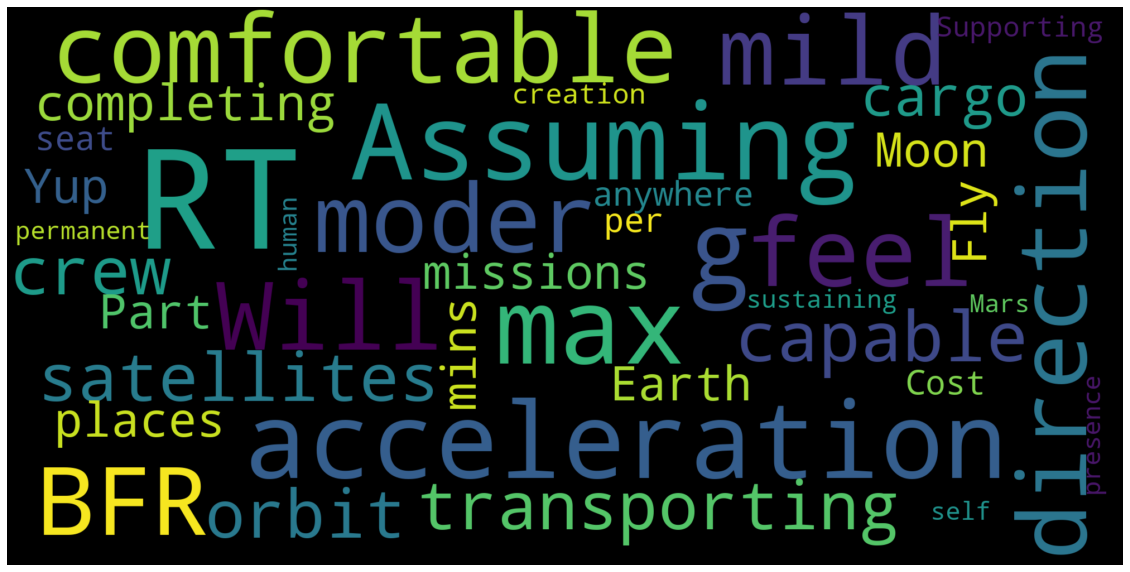

In [39]:
from wordcloud import WordCloud

text = ''
for i in range(len('tweets')):
    text += tweets['Cleaned_Tweet'][i]
wordcloud = WordCloud(max_font_size=50, max_words=200, scale = 5, background_color="black").generate(text)
plt.figure(figsize= (20,20), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<font size = '4'><b>6. Word Cloud - Positive, Negative and Neutral

In [40]:
import more_itertools
flattened_text = list(more_itertools.flatten(texts))

In [41]:
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in flattened_text:
    if (sid.polarity_scores(word)['compound']) >= 0.5:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.5:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)   

<font size = '3'>Positive Word Cloud

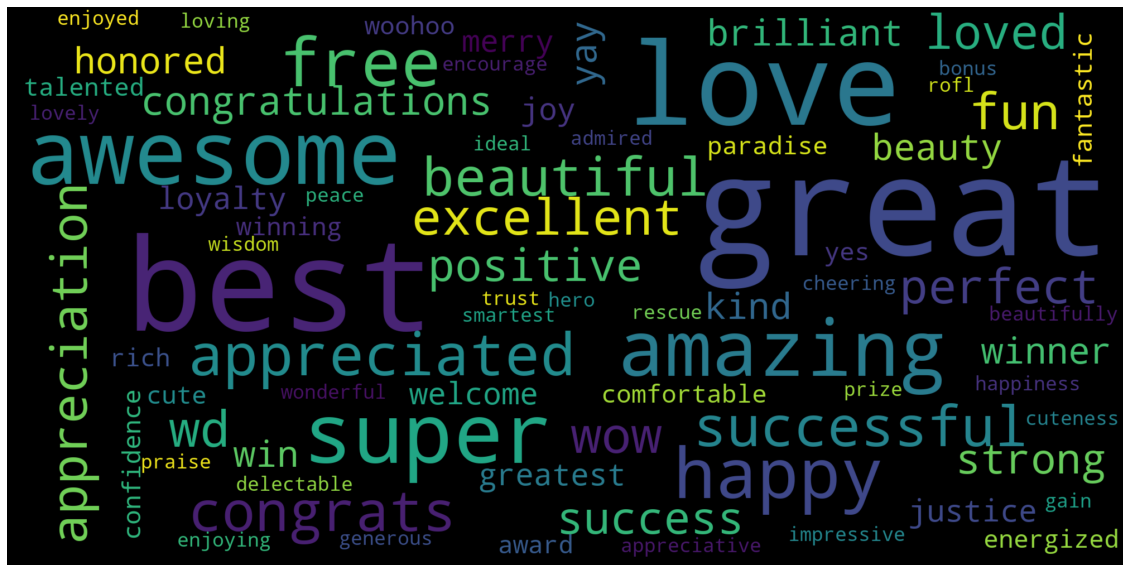

In [42]:
positive_string = ''
for i in range(len(pos_word_list)):
    positive_string = positive_string+ " " +pos_word_list[i]

wordcloud = WordCloud(max_font_size=50, max_words=200,scale = 5, background_color="black").generate(positive_string)
plt.figure(figsize= (20,20), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<font size = '3'>Negative Word Cloud

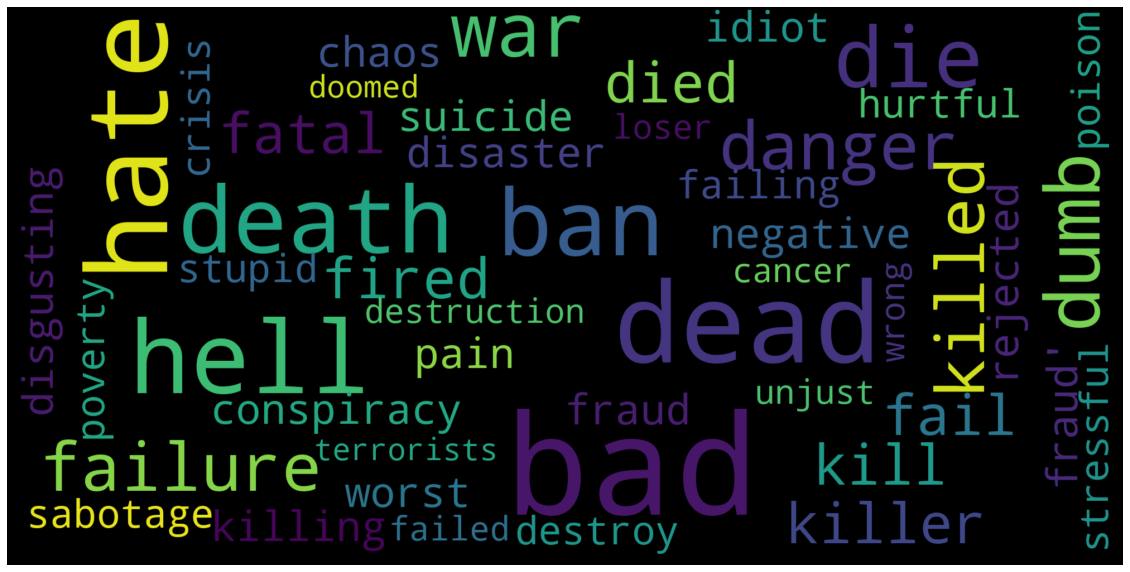

In [43]:
negative_string = ''
for i in range(len(neg_word_list)):
    negative_string = negative_string+ " " +neg_word_list[i]

wordcloud = WordCloud(max_font_size=50, max_words=200, scale = 5, background_color="black").generate(negative_string)
plt.figure(figsize= (20,20), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<font size = '3'>Neutral Word Cloud

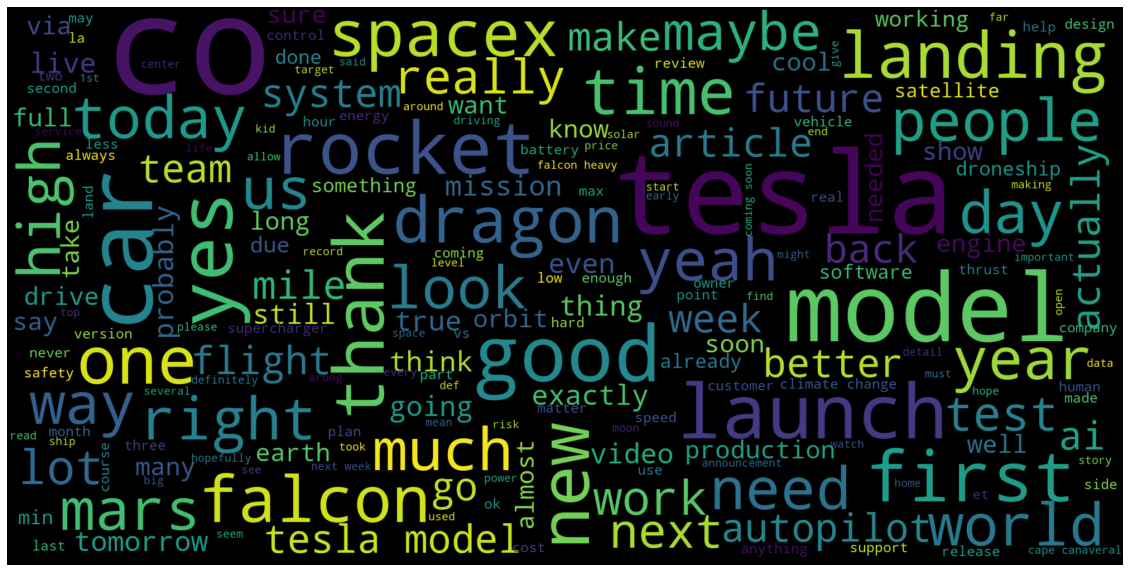

In [44]:
neutral_string = ''
for i in range(len(neu_word_list)):
    neutral_string = neutral_string + " " + neu_word_list[i]

wordcloud = WordCloud(max_font_size=50, max_words=200, scale = 5, background_color="black").generate(neutral_string)
plt.figure(figsize= (20,20), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()